# New York State Assembled Workers 

## Data Source
https://www.kaggle.com/new-york-state/nys-assembled-workers'-compensation-claims
https://data.ny.gov/Government-Finance/Assembled-Workers-Compensation-Claims-Beginning-20/jshw-gkgu

OIICS Codes (appears version 1.01 used): <br>
https://wwwn.cdc.gov/wisards/oiics/Trees/MultiTree.aspx?Year=2007

Understanding the claims process: <br>
http://www.wcb.ny.gov/content/main/onthejob/HowSystemWorks.jsp

New York State Regions: <br>
https://en.wikipedia.org/wiki/Category:Regions_of_New_York_(state)


## Info about data from Kaggle:
Content<br>
The Workers’ Compensation Board (WCB) administers and regulates workers’ compensation benefits, disability benefits, volunteer firefighters’ benefits, volunteer ambulance workers’ benefits, and volunteer civil defense workers’ benefits. The WCB processes and adjudicates claims for benefits; ensures employer compliance with the requirement to maintain appropriate insurance coverage; and regulates the various system stakeholders, including self-insured employers, medical providers, third party administrators, insurance carriers and legal representatives. Claim assembly occurs when the WCB learns of a workplace injury and assigns the claim a WCB claim number. The WCB “assembles” a claim in which an injured worker has lost more than one week of work, has a serious injury that may result in a permanent disability, is disputed by the carrier or employer, or receives a claim form from the injured worker (Form C-3). A reopened claim is one that has been reactivated to resolve new issues following a finding that no further action was necessary<br>

Context<br>
This is a dataset hosted by the State of New York. The state has an open data platform found here and they update their information according the amount of data that is brought in. Explore New York State using Kaggle and all of the data sources available through the State of New York organization page!<br>

Update Frequency: This dataset is updated quarterly.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

% matplotlib inline

In [2]:
data_path = 'nys-assembled-workers\'-compensation-claims/assembled-workers-compensation-claims-beginning-2000.csv'

parse_dates = ['Assembly Date', 'Accident Date', 'ANCR Date', 'Controverted Date', 'Section 32 Date', 
               'PPD Scheduled Loss Date', 'PPD Non-Scheduled Loss Date', 'PTD Date', 'First Appeal Date',
              'C-2 Date', 'C-3 Date', 'First Hearing Date']

df = pd.read_csv(data_path, parse_dates=parse_dates)   

# Change to booleans
df['Accident'] = np.where(df['Accident'] == 'Y', 1, 0)
df['Occupational Disease'] = np.where(df['Occupational Disease'] == 'Y', 1, 0)

# Change parameter into a boolean
df['Attorney/Representative'] = np.where(df['Attorney/Representative'] == 'Y', 1, 0)

# UK is an abbreviation used for unknown, change to nan
df.loc[df['WCIO Part Of Body Code'] == 'UK'] = np.nan
df.loc[df['WCIO Nature of Injury Code'] == 'UK'] = np.nan
df.loc[df['WCIO Cause of Injury Code'] == 'UK'] = np.nan

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Limit analysis to workers compensation claims
df = df[df['Claim Type'] == 'Workers Compensation']

# Remove outlier salaries, some may be errors
df = df[df['Average Weekly Wage'] < 20000]

# Create some features on insurance carrier
df['Private Ins'] = np.where(df['Carrier Type'] == '1A. PRIVATE', 1, 0)
df['SIF InS'] = np.where(df['Carrier Type'] == '2A. SIF', 1, 0)
df['Self Public Ins'] = np.where(df['Carrier Type'] == '3A. SELF PUBLIC', 1, 0)
df['Self Private Ins'] = np.where(df['Carrier Type'] == '4A. SELF PRIVATE', 1, 0)
df['MedRegion1'] = np.where(df['Medical Fee Region'] == 'I', 1, 0)
df['MedRegion2'] = np.where(df['Medical Fee Region'] == 'II', 1, 0)
df['MedRegion3'] = np.where(df['Medical Fee Region'] == 'III', 1, 0)
df['MedRegion4'] = np.where(df['Medical Fee Region'] == 'IV', 1, 0)
df['State Ins Fund'] = np.where(df['Carrier Name'] == 'STATE INSURANCE FUND', 1, 0) 

# Variabl tracking if insurance company protested claim
df['is_controverted'] = np.where(df['Controverted Date'].isnull() == 1, 0, 1)

# Add features about the location of the county of injury
counties = pd.read_csv('counties.csv', usecols=['Counties', 'Region', 'Upstate'])
df = df.merge(counties, left_on='County of Injury', right_on='Counties', how='left')
df.drop('Counties', axis=1, inplace=True)

df['GenderNum'] = 0
df.loc[df['Gender']== 'M', 'GenderNum'] = 1
df.loc[df['Gender']== 'F', 'GenderNum'] = 0
df.loc[df['Gender']== 'U', 'GenderNum'] = np.nan

#df['Body Code'] = pd.to_numeric(df['WCIO Part Of Body Code'])
#df['Nature Injury Code'] = pd.to_numeric(df['WCIO Nature of Injury Code'])
#df['Cause Injury Code'] = pd.to_numeric(df['WCIO Cause of Injury Code'])

# There are also impossibly old people in the dataset...

In [4]:
df.head()

,Claim Identifier,Claim Type,District Name,Average Weekly Wage,Current Claim Status,Claim Injury Type,Age at Injury,Assembly Date,Accident Date,ANCR Date,...,Self Public Ins,Self Private Ins,MedRegion1,MedRegion2,MedRegion3,MedRegion4,is_controverted,Region,Upstate,GenderNum
0,4037088.0,Workers Compensation,BUFFALO,610.00,HEARING UNSET,PPD NSL,37.0,2015-06-30,2015-05-14,2015-10-29,...,0,0,0,1,0,0,0,Western New York,1.0,1.0
1,4039191.0,Workers Compensation,ALBANY,215.88,NO FURTHER ACTION,PPD NSL,70.0,2015-07-10,2015-07-01,2015-11-12,...,0,0,0,1,0,0,0,Capital District,1.0,0.0
2,4044565.0,Workers Compensation,NYC,530.72,NO FURTHER ACTION,PPD NSL,30.0,2015-07-13,2015-02-22,2016-03-09,...,0,0,0,0,1,0,0,Hudson Valley,0.0,0.0
3,4054147.0,Workers Compensation,NYC,609.08,NO FURTHER ACTION,PPD NSL,63.0,2015-07-24,2015-04-10,2016-01-04,...,0,0,0,0,0,1,1,New York City,0.0,1.0
4,4054674.0,Workers Compensation,NYC,400.00,NO FURTHER ACTION,PPD NSL,41.0,2015-07-31,2015-05-06,2016-01-28,...,0,0,0,0,0,1,0,Long Island,0.0,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1377464 entries, 0 to 1377463
Data columns (total 63 columns):
Claim Identifier                      1377464 non-null float64
Claim Type                            1377464 non-null object
District Name                         1377464 non-null object
Average Weekly Wage                   1377464 non-null float64
Current Claim Status                  1377464 non-null object
Claim Injury Type                     1377464 non-null object
Age at Injury                         1377464 non-null float64
Assembly Date                         1377464 non-null datetime64[ns]
Accident Date                         1376860 non-null datetime64[ns]
ANCR Date                             606431 non-null datetime64[ns]
Controverted Date                     68455 non-null datetime64[ns]
Section 32 Date                       63728 non-null datetime64[ns]
PPD Scheduled Loss Date               123472 non-null datetime64[ns]
PPD Non-Scheduled Loss Date         

In [6]:
df['Current Claim Status'].unique()

array(['HEARING UNSET', 'NO FURTHER ACTION', 'HEARING SET',
       'RE-OPENED ADMINISTRATIVELY', 'ADMINISTRATIVELY CLOSED',
       'MOTION SET', 'ARGUMENT SET', 'REFEREE - RESERVED DECISION',
       'NEWLY ASSEMBLED', 'CASE CANCELLED', 'RETURNED TO EXAMINING',
       'BOARD RESTORAL'], dtype=object)

In [55]:
# How many data points claim age at injury is over 90?
df[df['Age at Injury'] >= 90]['Age at Injury'].count()

171

In [ ]:
features = ['Average Weekly Wage', 'Upstate'
       'Age at Injury', 'Body Code',
       'Nature Injury Code', 'Cause Injury Code', 
       'GenderNum', 'MedRegion1', 'MedRegion2', 'MedRegion3', 'MedRegion4', 
       'Attorney/Representative', 
       'IME-4 Count', 'Interval Assembled to ANCR', 'Accident',
       'Occupational Disease', 'Private Ins', 'SIF InS',
       'Self Public Ins', 'Self Private Ins', 'is_controverted']

## Injury Codes comparison

In [52]:
#pd.crosstab(df['WCIO Part Of Body Code'], df['is_controverted'])
def percConvert(ser):
  return ser/float(ser[-1])

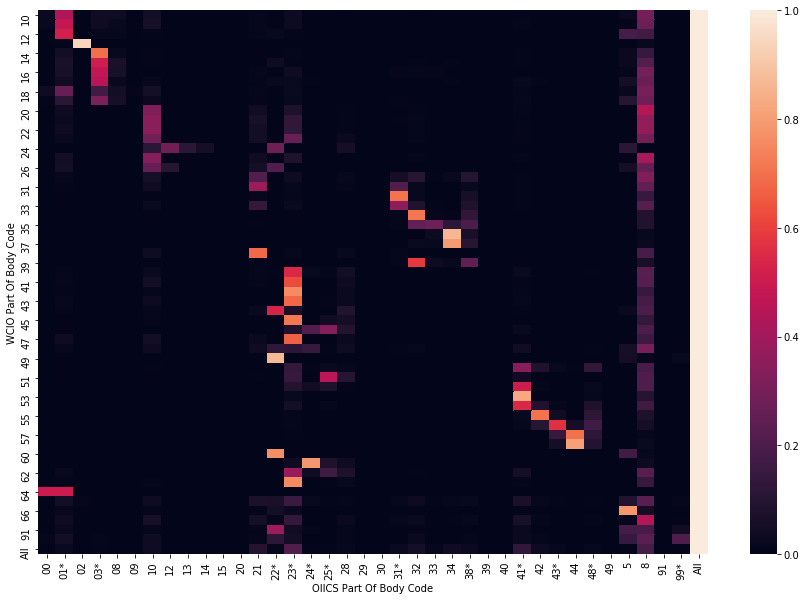

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(pd.crosstab(df['WCIO Part Of Body Code'],df['OIICS Part Of Body Code'], 
                        margins=True).apply(percConvert, axis=1))

The OIICS Part of Body Code 8 indicates multiple body parts. 23* is back includeing spine.  These two fields are nearly the same thing, but aren't always reported the exact same way. 

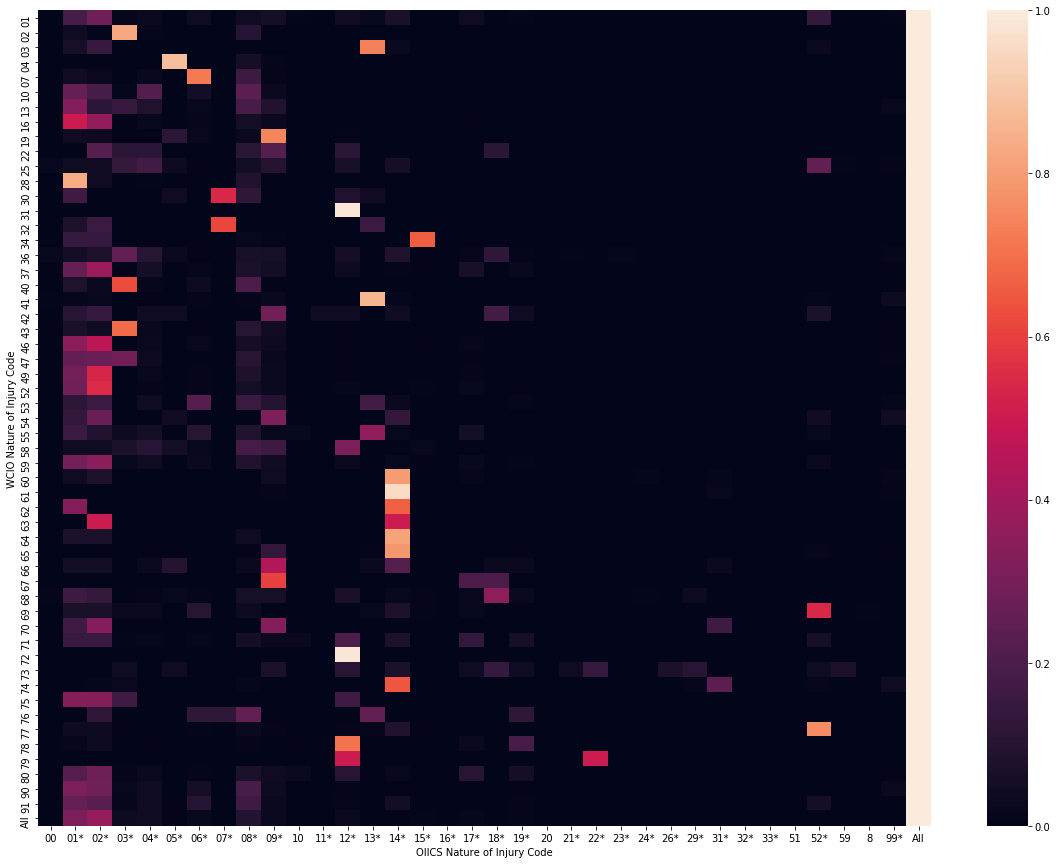

In [27]:
plt.figure(figsize=(20,15))
sns.heatmap(pd.crosstab(df['WCIO Nature of Injury Code'],df['OIICS Nature of Injury Code'], 
                        margins=True).apply(percConvert, axis=1))

The OIICS code 01* and 02* are:	01* : Traumatic injuries to bones, nerves, spinal cord,	02* : Traumatic injuries to muscles, tendons, ligaments, joints, etc.

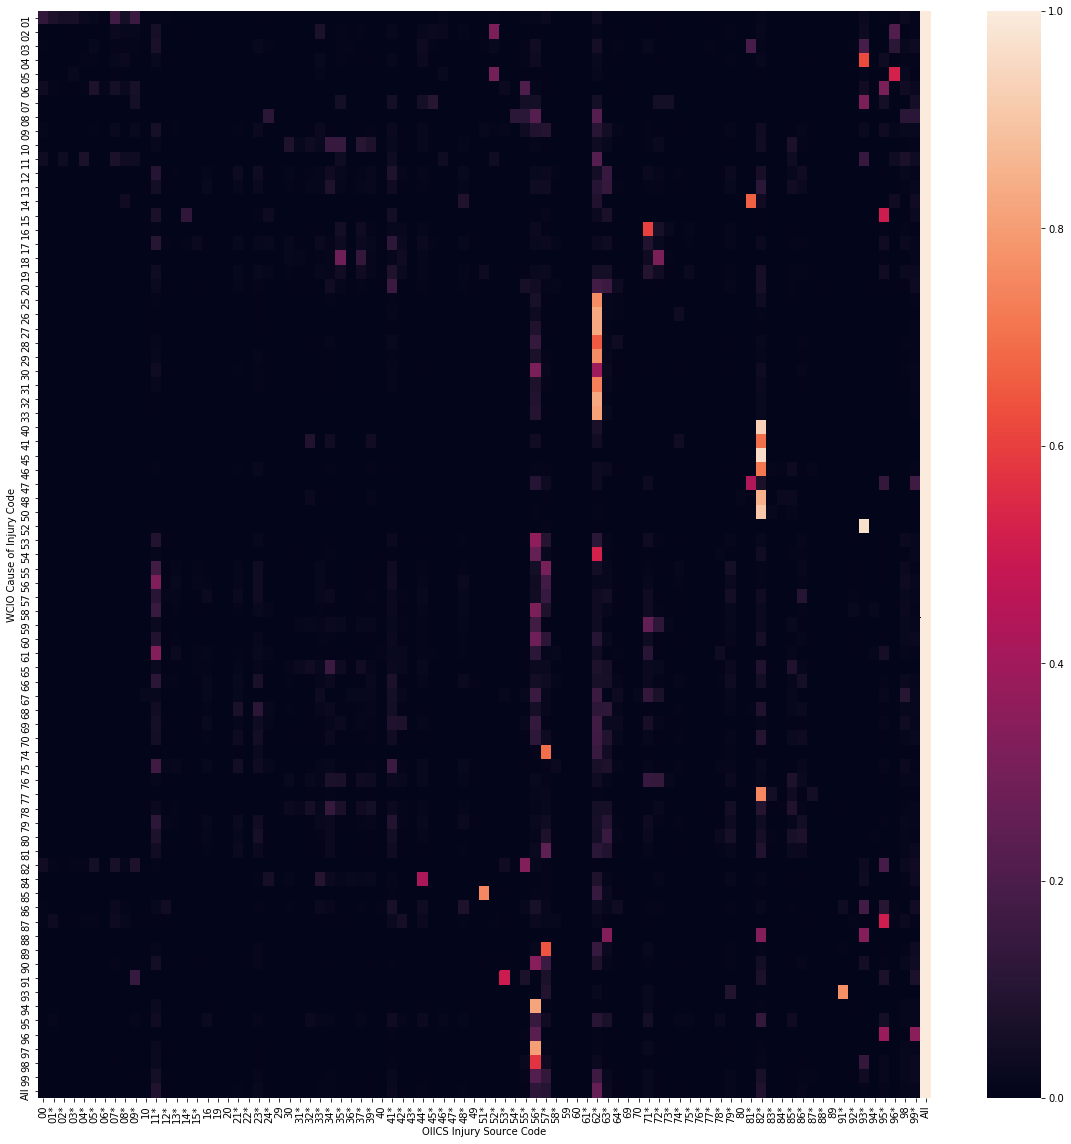

In [29]:
plt.figure(figsize=(20,20))
sns.heatmap(pd.crosstab(df['WCIO Cause of Injury Code'],df['OIICS Injury Source Code'],
                       margins=True).apply(percConvert, axis=1))

OIICS codes: 62* : Floors, walkways, ground surfaces, 56* : Person--injured or ill worker, 82* : Highway vehicle, motorized

### OIICS and WCIO codes are not the same
Take away from OIICS codes and WCIO codes, they are related, but not a 1:1 correlation between most of them.  Will need to try modeling with one or the other.

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


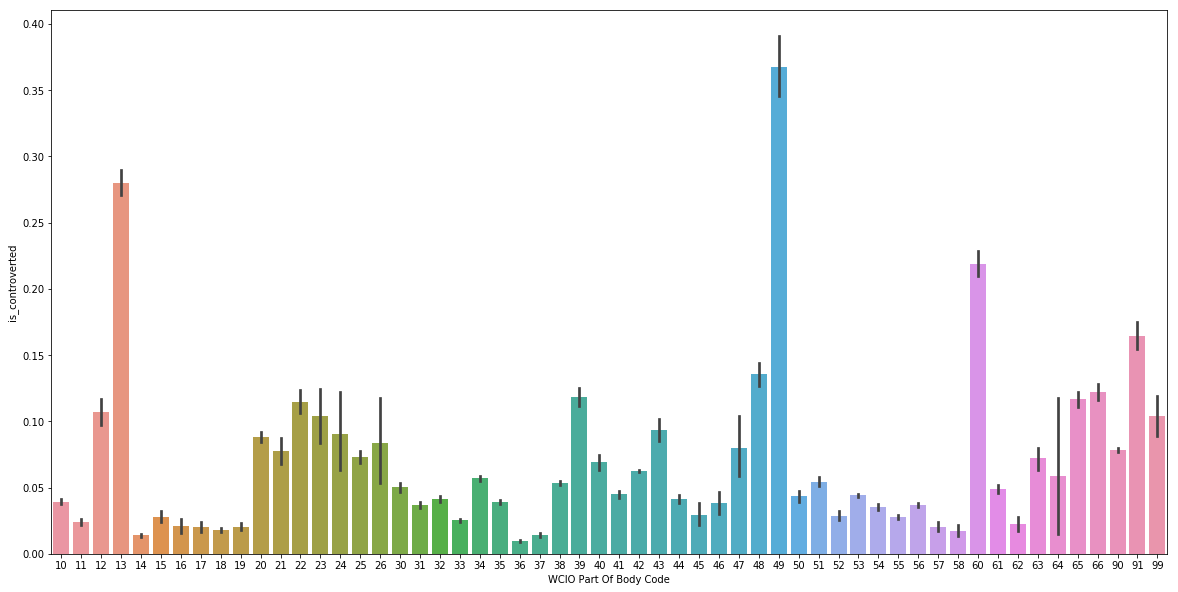

In [34]:
plt.figure(figsize=(20, 10))
sns.barplot(x='WCIO Part Of Body Code', y='is_controverted', data=df)

Code 13: Ears, Code 49: Heart, Code 60: Lungs, Code 91: BODY SYSTEMS AND MULTIPLE BODY SYSTEMS, Code 36: Fingers, Code 14: Eyes, Code 58: Great Toe

## Calculate the Binomial Error bars for the top 3

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


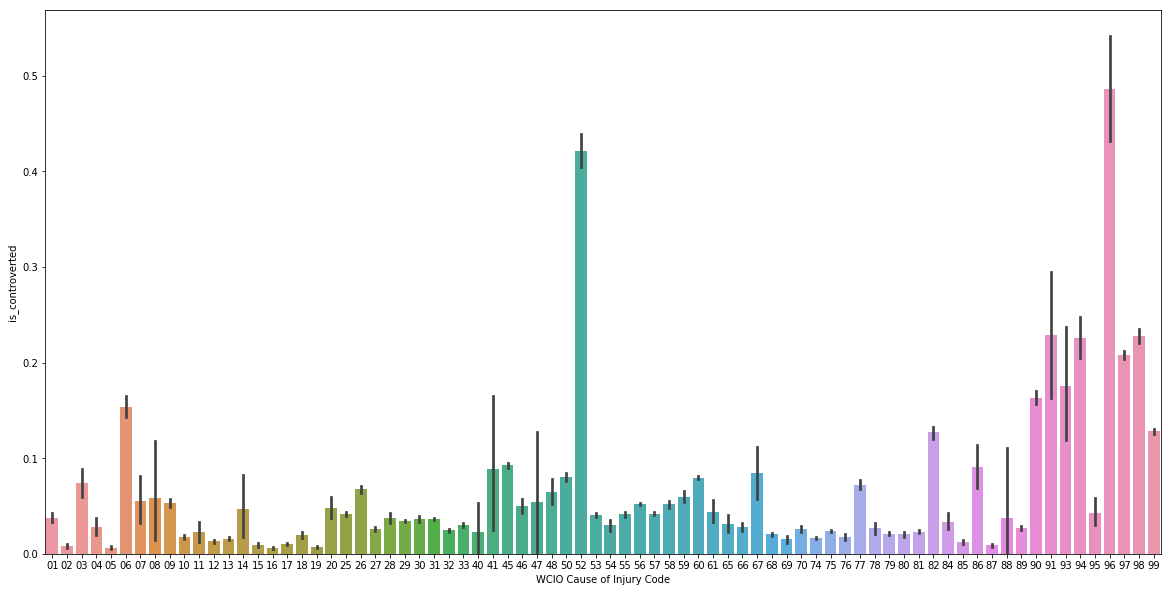

In [42]:
plt.figure(figsize=(20, 10))
sns.barplot(x='WCIO Cause of Injury Code', y='is_controverted', data=df)

52: Continual Noise, 96: Terrorism, 91: Mold, 94: Repetitive Motion, 98: Cumulative, no other code, 97: Repetitive motion (2 of these?), 2: Amputation, 5: 

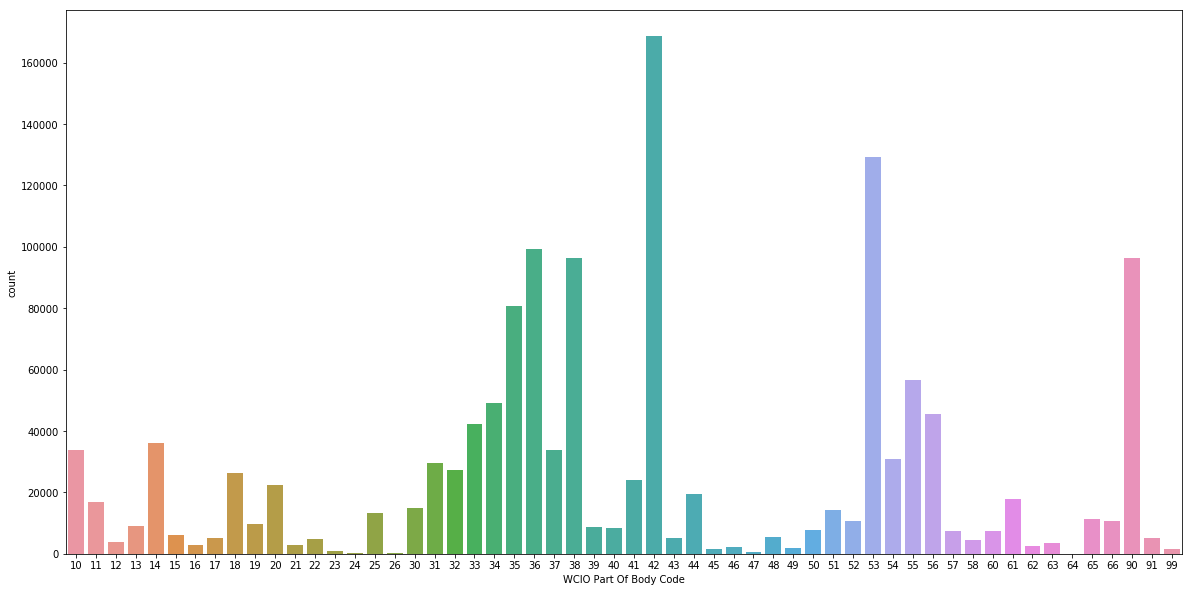

In [47]:
# Checking to see which injuries are the most common, are they also the most commonly protested?
plt.figure(figsize=(20, 10))
sns.countplot(x='WCIO Part Of Body Code', data=df)

42: Lower Back, 53: Knee, 90: Multiple parts - These are not the same ones that are most frequently protested by insurance companies

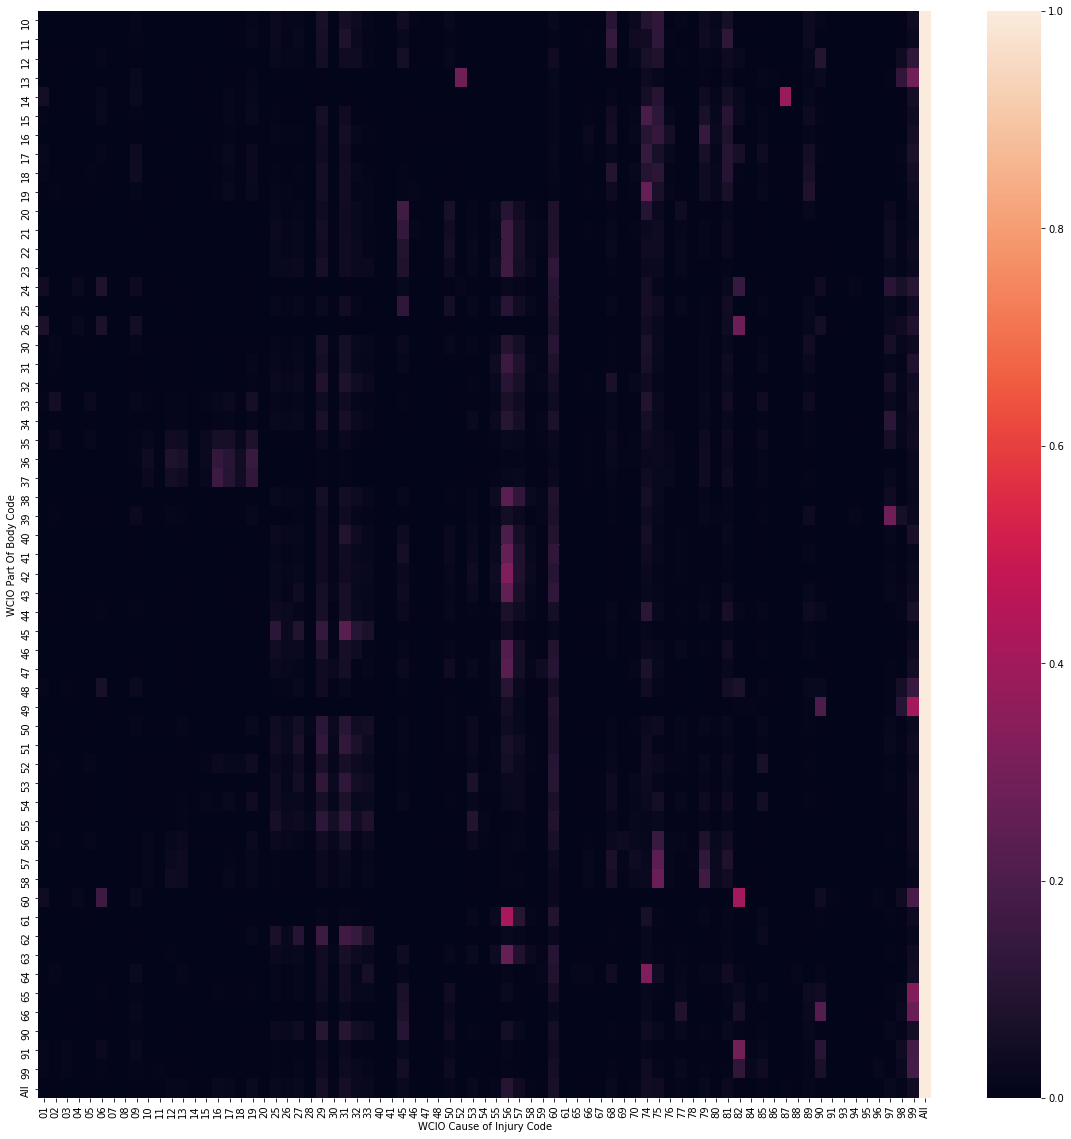

In [50]:
plt.figure(figsize=(20,20))
sns.heatmap(pd.crosstab(df['WCIO Part Of Body Code'],df['WCIO Cause of Injury Code'],
                       margins=True).apply(percConvert, axis=1))

The body part injured and cause of injury are related, but not 1:1. Should consider keeping both for modeling.

##  Demographics

### Gender, wages, and protested

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


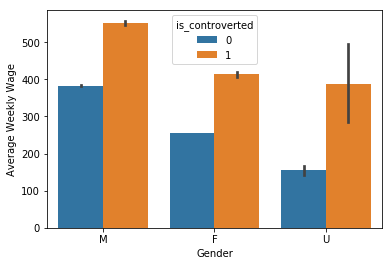

In [58]:
sns.barplot(x='Gender', y='Average Weekly Wage', hue='is_controverted', data=df)

# Throw in some statistics about salary and controverted claims

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


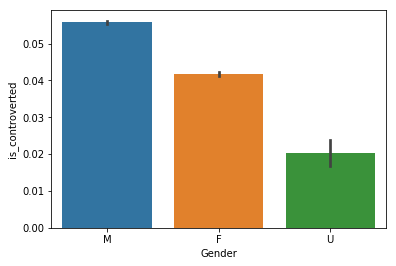

In [66]:
sns.barplot(x='Gender', y='is_controverted', data=df)

Interesting, it appears that more cases from men are disputed than from women.

Average Weekly Salary

Not Controverted: 327.653638
Controverted: 502.317087


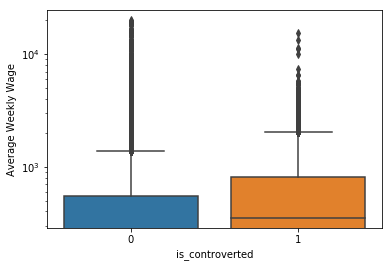

In [69]:
g = sns.boxplot(x='is_controverted', y='Average Weekly Wage', data=df)
g.set_yscale('log')
plt.title('Salary and controverted claims')

print('Average Weekly Salary\n')
print('Not Controverted: {:2f}'.format(df[df['is_controverted'] == 0]['Average Weekly Wage'].mean()))
print('Controverted: {:2f}'.format(df[df['is_controverted'] == 1]['Average Weekly Wage'].mean()))

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


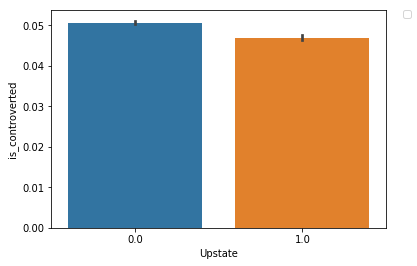

In [120]:
# Look at whether or not certain regions of New York have more claimes rejected
sns.barplot(x='Upstate', y='is_controverted', data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


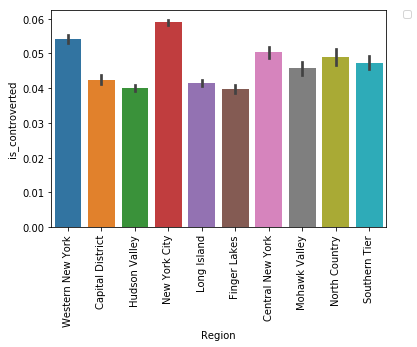

In [121]:
sns.barplot(x='Region', y='is_controverted', data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=90)
plt.show()

Upstate has a lower rate of controverted claims.  New York City (down state) has the hightest rate.

## Timing

(-50, 700)

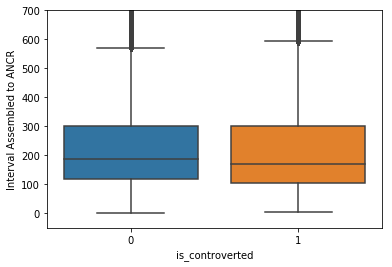

In [79]:
# This is a measure of how long it takes for the WCB board to consider the paperwork complete
# Does not appear to have much of a difference between controverted and not.

g = sns.boxplot(x='is_controverted', y='Interval Assembled to ANCR', data=df)
plt.title('Time to ANCR')
plt.ylim(-50, 700)


In [132]:
df['Accident Year'] = df['Accident Date'].dt.year
df['Accident Month'] = df['Accident Date'].dt.month
df['Accident Day'] = df['Accident Date'].dt.dayofweek

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


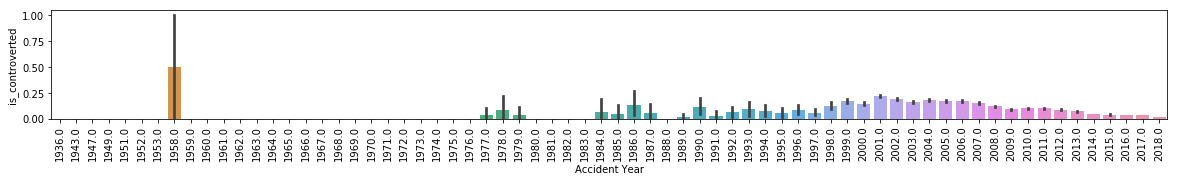

In [141]:
plt.figure(figsize=(20, 2))
sns.barplot(x='Accident Year', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


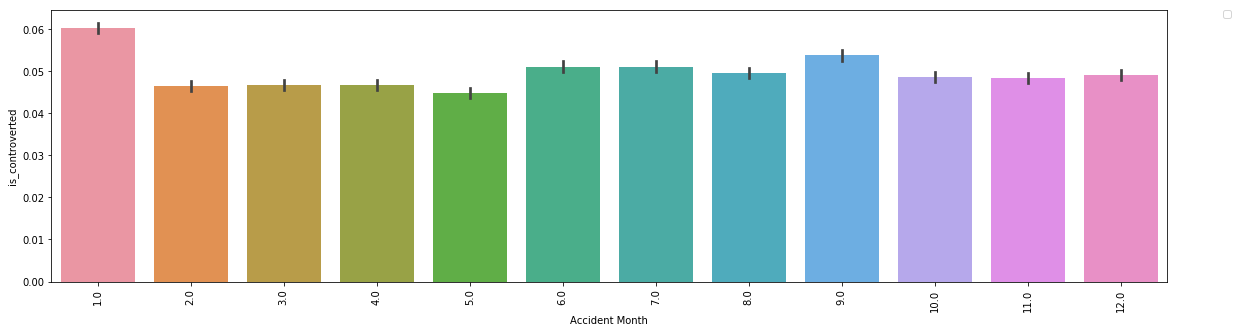

In [139]:
plt.figure(figsize=(20, 5))
sns.barplot(x='Accident Month', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


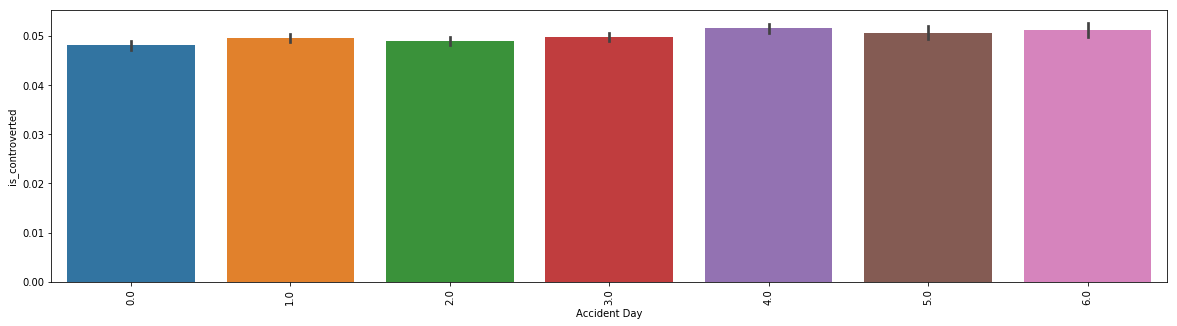

In [140]:
# Monday is 0, Sunday is 6
plt.figure(figsize=(20, 5))
sns.barplot(x='Accident Day', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

In [142]:
df['Assembly Year'] = df['Assembly Date'].dt.year
df['Assembly Month'] = df['Assembly Date'].dt.month
df['Assembly Day'] = df['Assembly Date'].dt.dayofweek

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


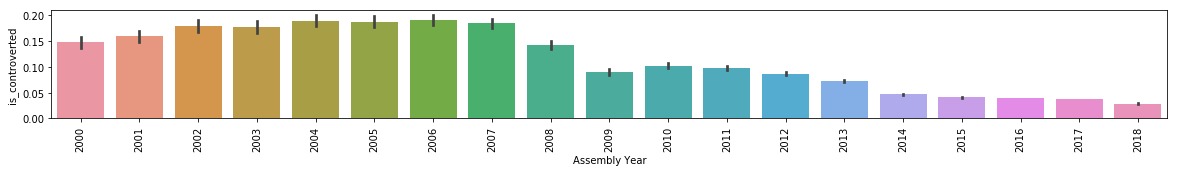

In [143]:
plt.figure(figsize=(20, 2))
sns.barplot(x='Assembly Year', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


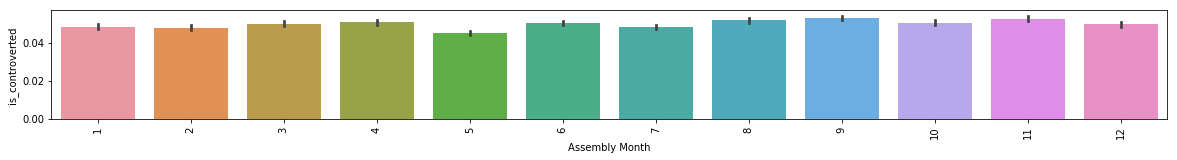

In [145]:
plt.figure(figsize=(20, 2))
sns.barplot(x='Assembly Month', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


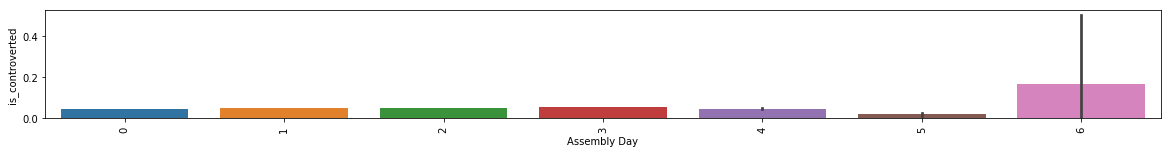

In [146]:
# This state employees are unlikely to be working on weekends (5 or 6)
plt.figure(figsize=(20, 2))
sns.barplot(x='Assembly Day', y='is_controverted', data=df)
plt.xticks(rotation=90)
plt.show()

## Looking at the insurance carriers

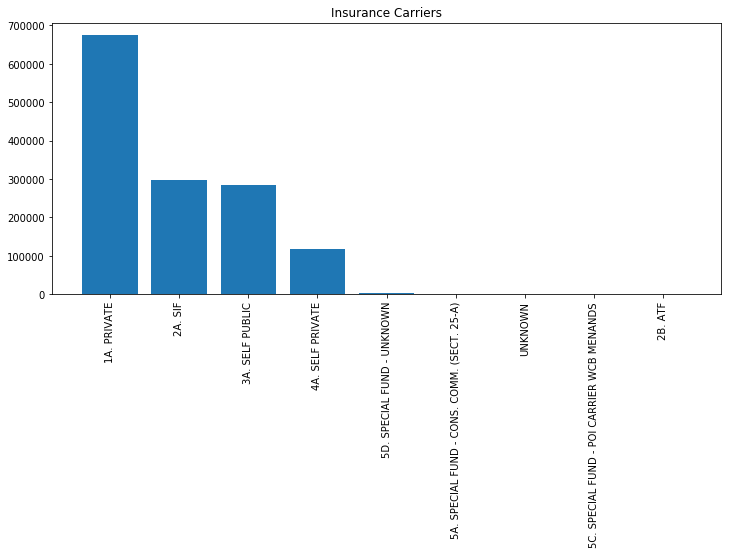

In [89]:
ins_types_plot = df.groupby(by='Carrier Type')['Carrier Type'].count()
ins_types_plot = ins_types_plot.sort_values(ascending=False)
plt.figure(figsize=(12, 5))
plt.bar(ins_types_plot.index, ins_types_plot)
plt.title('Insurance Carriers')

plt.show()

There are 1465 different insurance carriers.
State Insurance Fund is the largest carrier


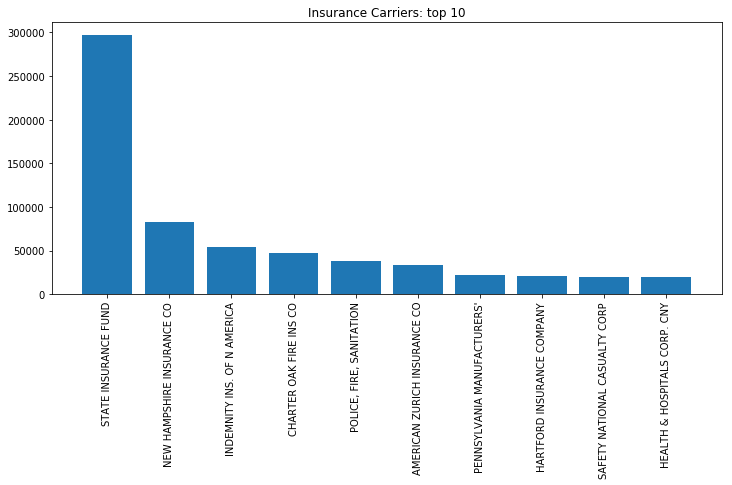

In [107]:
carrier_plot = df.groupby(by='Carrier Name')['Carrier Name'].count()
carrier_plot = carrier_plot.sort_values(ascending=False)[:10]
plt.figure(figsize=(12, 5))
plt.bar(carrier_plot.index, carrier_plot)
plt.xticks(rotation=90)
plt.title('Insurance Carriers: top 10')

print('There are {} different insurance carriers.'.format(len(df['Carrier Name'].unique())))
print('State Insurance Fund is the largest carrier')
plt.show()

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

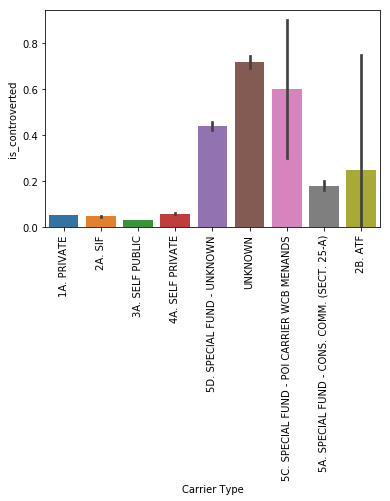

In [109]:
sns.barplot(x='Carrier Type', y='is_controverted', data=df)
plt.xticks(rotation=90)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


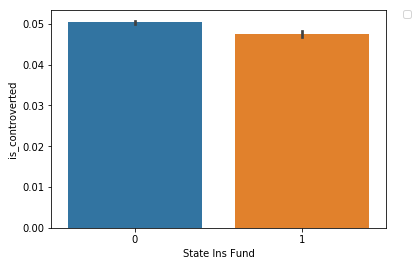

In [111]:
# Look at whether or not the state insurance fund has a higher/lower rate
# of controverted claims
sns.barplot(x='State Ins Fund', y='is_controverted', data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()